In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('../data/boston_housing.csv')

In [4]:
df_encoded = pd.get_dummies(df, columns=['rad'], prefix='rad', drop_first=True)

In [5]:
# Separate features and target
X = df_encoded.drop('medv', axis=1)
y = df_encoded['medv']

In [6]:
# Standardize numerical features
numerical_cols = ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'b', 'lstat']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 1. Choose Appropriate Features
# Calculate correlation with target to select features
correlation = df_encoded.corr()['medv'].abs().sort_values(ascending=False)
print("Correlation with 'medv':")
print(correlation)

Correlation with 'medv':
medv       1.000000
lstat      0.737663
rm         0.695360
ptratio    0.507787
indus      0.483725
tax        0.468536
nox        0.427321
rad_24     0.396297
crim       0.388305
age        0.376955
zn         0.360445
b          0.333461
dis        0.249929
rad_8      0.190053
rad_5      0.187356
chas       0.175260
rad_3      0.167352
rad_2      0.104444
rad_7      0.092802
rad_4      0.065711
rad_6      0.039411
Name: medv, dtype: float64


In [9]:
# Select features with correlation > 0.3 (arbitrary threshold for relevance)
selected_features = correlation[correlation > 0.3].index.drop('medv').tolist()
print("\nSelected Features:", selected_features)


Selected Features: ['lstat', 'rm', 'ptratio', 'indus', 'tax', 'nox', 'rad_24', 'crim', 'age', 'zn', 'b']


In [10]:
# Update X_train and X_test with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [11]:
# 2. Train a Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_selected, y_train)

LinearRegression()

In [12]:
# Predict and evaluate
y_pred_lr = lr_model.fit(X_train_selected, y_train)
y_pred_lr = lr_model.predict(X_test_selected)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Performance:")
print(f"Mean Squared Error (MSE): {lr_mse:.2f}")
print(f"R^2 Score: {lr_r2:.2f}")


Linear Regression Performance:
Mean Squared Error (MSE): 28.41
R^2 Score: 0.61


In [13]:
# Cross-validation for robustness
cv_scores_lr = cross_val_score(lr_model, X_train_selected, y_train, cv=5, scoring='r2')
print(f"Cross-Validated R^2 Scores: {cv_scores_lr}")
print(f"Average CV R^2: {cv_scores_lr.mean():.2f} (± {cv_scores_lr.std() * 2:.2f})")

Cross-Validated R^2 Scores: [0.77338649 0.5968363  0.69508335 0.76867168 0.62689626]
Average CV R^2: 0.69 (± 0.14)


In [14]:
# 3. Hyperparameter Tuning with Ridge Regression
# Ridge regression adds regularization, with 'alpha' as the key hyperparameter
ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
             return_train_score=True, scoring='r2')

In [15]:
# Best model results
best_ridge = grid_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_selected)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print("\nRidge Regression Performance (after tuning):")
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Mean Squared Error (MSE): {ridge_mse:.2f}")
print(f"R^2 Score: {ridge_r2:.2f}")


Ridge Regression Performance (after tuning):
Best Alpha: 1.0
Mean Squared Error (MSE): 28.53
R^2 Score: 0.61


In [16]:
# Cross-validation for best Ridge model
cv_scores_ridge = cross_val_score(best_ridge, X_train_selected, y_train, cv=5, scoring='r2')
print(f"Cross-Validated R^2 Scores: {cv_scores_ridge}")
print(f"Average CV R^2: {cv_scores_ridge.mean():.2f} (± {cv_scores_ridge.std() * 2:.2f})")

Cross-Validated R^2 Scores: [0.77216259 0.59693985 0.69386943 0.77017897 0.6278633 ]
Average CV R^2: 0.69 (± 0.14)


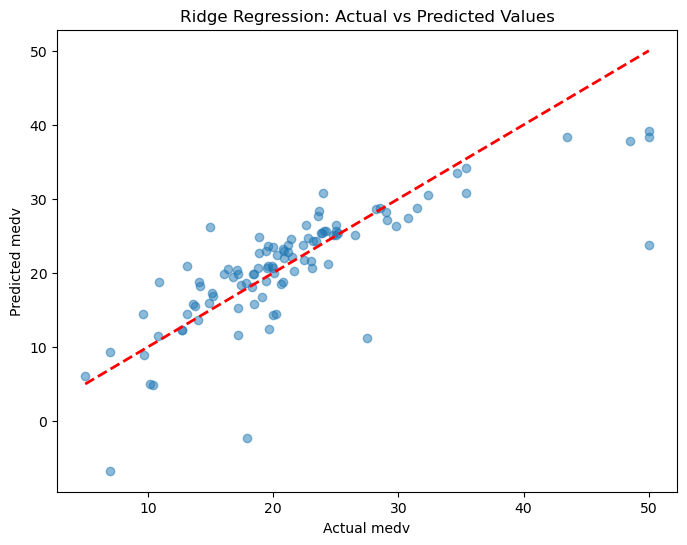

In [17]:
# Visualize predictions vs actual values for Ridge
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Ridge Regression: Actual vs Predicted Values')
plt.xlabel('Actual medv')
plt.ylabel('Predicted medv')
plt.show()